load dataset

In [1]:
import pandas as pd

url = './drive/MyDrive/Dataset Colabs/Time Series/bitcoin.csv'
data = pd.read_csv(url, parse_dates=['Date'], index_col='Date')
data

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2014-01-07,874.67040,892.06753,810.00000,810.00000,15.622378,1.315147e+04,841.835522
2014-01-08,810.00000,899.84281,788.00000,824.98287,19.182756,1.609733e+04,839.156269
2014-01-09,825.56345,870.00000,807.42084,841.86934,8.158335,6.784250e+03,831.572913
2014-01-10,839.99000,857.34056,817.00000,857.33056,8.024510,6.780220e+03,844.938794
2014-01-11,858.20000,918.05471,857.16554,899.84105,18.748285,1.669857e+04,890.671709
...,...,...,...,...,...,...,...
2017-10-13,5429.80000,5854.40000,5380.10000,5640.00000,9222.144339,5.178706e+07,5615.511555
2017-10-14,5626.70000,5800.00000,5556.10000,5800.00000,3019.946476,1.719205e+07,5692.831135
2017-10-15,5800.00000,5840.40000,5462.10000,5680.00000,4536.386215,2.545265e+07,5610.777658


cek data set info 

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1380 entries, 2014-01-07 to 2017-10-17
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Open               1380 non-null   float64
 1   High               1380 non-null   float64
 2   Low                1380 non-null   float64
 3   Close              1380 non-null   float64
 4   Volume (BTC)       1380 non-null   float64
 5   Volume (Currency)  1380 non-null   float64
 6   Weighted Price     1380 non-null   float64
dtypes: float64(7)
memory usage: 86.2 KB


cek null data

In [3]:
data.isnull().sum()

Open                 0
High                 0
Low                  0
Close                0
Volume (BTC)         0
Volume (Currency)    0
Weighted Price       0
dtype: int64

cek pattern in weighted price each month

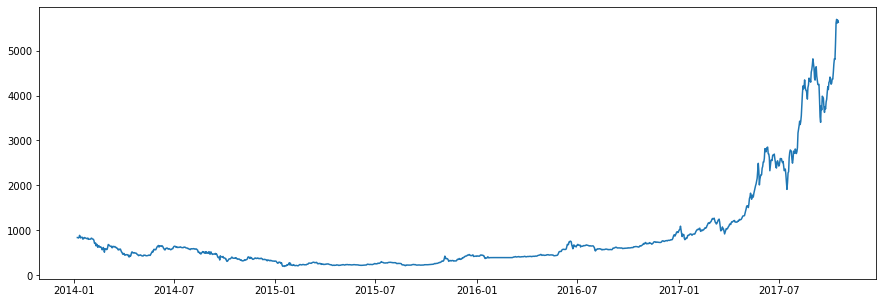

In [4]:
import matplotlib.pyplot as plt

time = data.index.values
test = data['Weighted Price'].values

plt.figure(figsize=(15,5))
plt.plot(time, test)

normalize weighted price using MinMaxScaler()

In [5]:
from sklearn.preprocessing import MinMaxScaler
values = data['Weighted Price'].values.reshape(-1,1)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

split data into 80% train 20% test

In [6]:
train_size = int(len(scaled) * 0.8)
test_size = len(scaled) - train_size
train, test = scaled[0:train_size,:], scaled[train_size:len(scaled),:]
print(len(train), len(test))

1104 276


create create_dataset() function

In [7]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

generate dataset using create_dataset() function

In [8]:
import numpy as np
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

1103
275


reshape for model training

In [9]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

create myCallback() function to stop training when achieve mae < 0.01

In [10]:
import tensorflow as tf

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae') < 0.01):
      print("MAE has reached below 10%")
      self.model.stop_training = True
callbacks = myCallback()

build sequential model with 1 layer LSTM and Dense

In [11]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])),
    # tf.keras.layers.LSTM(128),
    # tf.keras.layers.Dropout(rate=0.2),
    # tf.keras.layers.Dense(30, activation="relu"),
    # tf.keras.layers.Dense(1, activation="relu"),
    tf.keras.layers.Dense(1)
])

using learning rate as optimizer, and mae as metrics

In [12]:
# optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
# model.compile(loss=tf.keras.losses.Huber(),
#               optimizer=optimizer,
#               metrics=["mae"])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

training model with 300 epochs, and shuffle false

In [13]:
history = model.fit(trainX, trainY,
                    epochs=300,
                    batch_size=100,
                    validation_data=(testX, testY),
                    verbose=2,
                    callbacks = callbacks,
                    shuffle=False)

Epoch 1/300
12/12 - 3s - loss: 0.0018 - mae: 0.0525 - val_loss: 0.0687 - val_mae: 0.3139 - 3s/epoch - 290ms/step
Epoch 2/300
12/12 - 0s - loss: 8.6008e-04 - mae: 0.0362 - val_loss: 0.0505 - val_mae: 0.2615 - 74ms/epoch - 6ms/step
Epoch 3/300
12/12 - 0s - loss: 4.5367e-04 - mae: 0.0253 - val_loss: 0.0438 - val_mae: 0.2465 - 73ms/epoch - 6ms/step
Epoch 4/300
12/12 - 0s - loss: 4.2797e-04 - mae: 0.0255 - val_loss: 0.0265 - val_mae: 0.1915 - 74ms/epoch - 6ms/step
Epoch 5/300
12/12 - 0s - loss: 2.5973e-04 - mae: 0.0195 - val_loss: 0.0112 - val_mae: 0.1263 - 78ms/epoch - 7ms/step
Epoch 6/300
12/12 - 0s - loss: 1.6195e-04 - mae: 0.0156 - val_loss: 0.0011 - val_mae: 0.0400 - 71ms/epoch - 6ms/step
Epoch 7/300
MAE has reached below 10%
12/12 - 0s - loss: 3.2886e-05 - mae: 0.0068 - val_loss: 0.0027 - val_mae: 0.0487 - 89ms/epoch - 7ms/step


visualize the history between loss and mae of training model

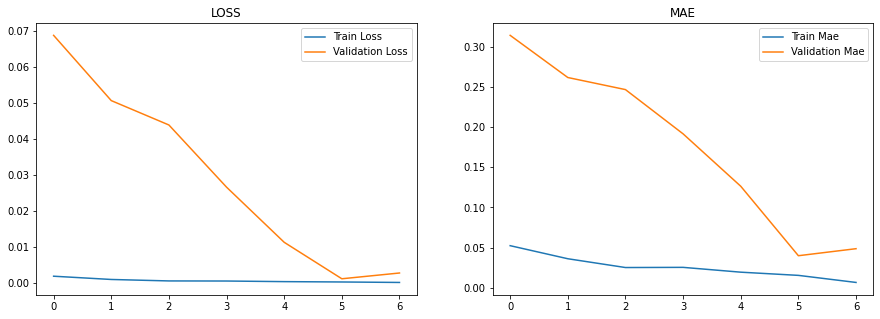

In [14]:
def final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('LOSS')
    ax[0].plot(history.epoch, history.history["loss"], label="Train Loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation Loss")
    ax[1].set_title('MAE')
    ax[1].plot(history.epoch, history.history["mae"], label="Train Mae")
    ax[1].plot(history.epoch, history.history["val_mae"], label="Validation Mae")
    ax[0].legend()
    ax[1].legend()

final_history(history)